In [1]:
import datetime as dt
import itertools
from pathlib import Path

import cartopy.crs as ccrs
import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import interpolate
import xarray as xr

from remake import load_remake

from mcs_prime import PATHS, McsTracks, PixelData
from mcs_prime.util import update_progress
%matplotlib inline

Load all tracks from 2000/6-2020/12

In [2]:
mle = load_remake('../../remakefiles/mcs_local_envs.py')

In [3]:
t = mle.McsLocalEnv.tasks[0]

In [4]:
ds = xr.open_dataset(t.outputs['mcs_local_env'])

In [5]:
ds

<xarray.Dataset>
Dimensions:         (time: 1, latitude: 481, longitude: 1440)
Coordinates:
  * time            (time) datetime64[ns] 2020-01-01T12:00:00
  * latitude        (latitude) float32 60.0 59.75 59.5 ... -59.5 -59.75 -60.0
  * longitude       (longitude) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    cape            (time, latitude, longitude) float64 ...
    mcs_local_cape  (time, latitude, longitude) float64 ...
    tcwv            (time, latitude, longitude) float64 ...
    mcs_local_tcwv  (time, latitude, longitude) float64 ...

In [6]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)
fig.set_size_inches((20, 10))

vmax = max(np.max(ds.cape.values[0]), np.nanmax(ds.mcs_local_cape.values[0]))

ax1.contourf(ds.longitude, ds.latitude, ds.cape[0], vmin=0, vmax=vmax)
ax2.contourf(ds.longitude, ds.latitude, ds.mcs_local_cape[0], vmin=0, vmax=vmax)
ax1.coastlines()
ax2.coastlines()

In [7]:
paths = [t.outputs['mcs_local_env'] for t in mle.CombineMonthlyMcsLocalEnv.tasks]
len(paths)

12

In [8]:
paths[:5]

[PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/01/mcs_local_env_2020_01.nc'),
 PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/02/mcs_local_env_2020_02.nc'),
 PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/03/mcs_local_env_2020_03.nc'),
 PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/04/mcs_local_env_2020_04.nc'),
 PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/mcs_prime_output/mcs_local_envs/2020/05/mcs_local_env_2020_05.nc')]

In [9]:
ds = xr.open_mfdataset(paths).load()

In [32]:
def plot_var(ds, var):
    fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)
    fig.set_size_inches((20, 15))
    
    vmax = max(np.max(ds[var].values), np.nanmax(ds[f'mcs_local_{var}'].values))
    diff = (ds[f'mcs_local_{var}'] - ds[var])
    absmax_diff = np.abs(diff).max()
    
    im1 = ax1.contourf(ds.longitude, ds.latitude, ds[var], vmin=0, vmax=vmax)
    im2 = ax2.contourf(ds.longitude, ds.latitude, ds[f'mcs_local_{var}'], vmin=0, vmax=vmax)
    im3 = ax3.contourf(ds.longitude, ds.latitude, diff, vmin=-absmax_diff, vmax=absmax_diff, cmap='bwr')
    
    ax1.coastlines()
    ax2.coastlines()
    ax3.coastlines()
    plt.colorbar(im1, ax=[ax1, ax2])
    plt.colorbar(im3, ax=ax3)

    
def plot_var_diff(ds, var, title):
    fig, ax1 = plt.subplots(
    1, 1,
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)
    fig.set_size_inches((20, 5))
    plt.title(title)
    
    diff = (ds[f'mcs_local_{var}'] - ds[var])
    absmax_diff = np.abs(diff).max()
    if var == 'cape':
        levels = np.linspace(-2000, 2000, 11)
    elif var == 'tcwv':
        levels = np.linspace(-40, 40, 11)
    
    im1 = ax1.contourf(ds.longitude, ds.latitude, diff, levels=levels, cmap='bwr')
    
    ax1.coastlines()
    plt.colorbar(im1, ax=ax1, extend='both')

In [15]:
ds

<xarray.Dataset>
Dimensions:         (time: 12, latitude: 481, longitude: 1440)
Coordinates:
  * latitude        (latitude) float32 60.0 59.75 59.5 ... -59.5 -59.75 -60.0
  * longitude       (longitude) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time            (time) datetime64[ns] 2020-01-16T12:00:00 ... 2020-12-16T...
Data variables:
    cape            (time, latitude, longitude) float64 13.97 13.78 ... 9.244
    mcs_local_cape  (time, latitude, longitude) float64 6.397 6.251 ... nan nan
    tcwv            (time, latitude, longitude) float64 12.19 12.17 ... 8.155
    mcs_local_tcwv  (time, latitude, longitude) float64 26.31 26.09 ... nan nan

In [27]:
plot_var(ds.isel(time=0), 'cape')

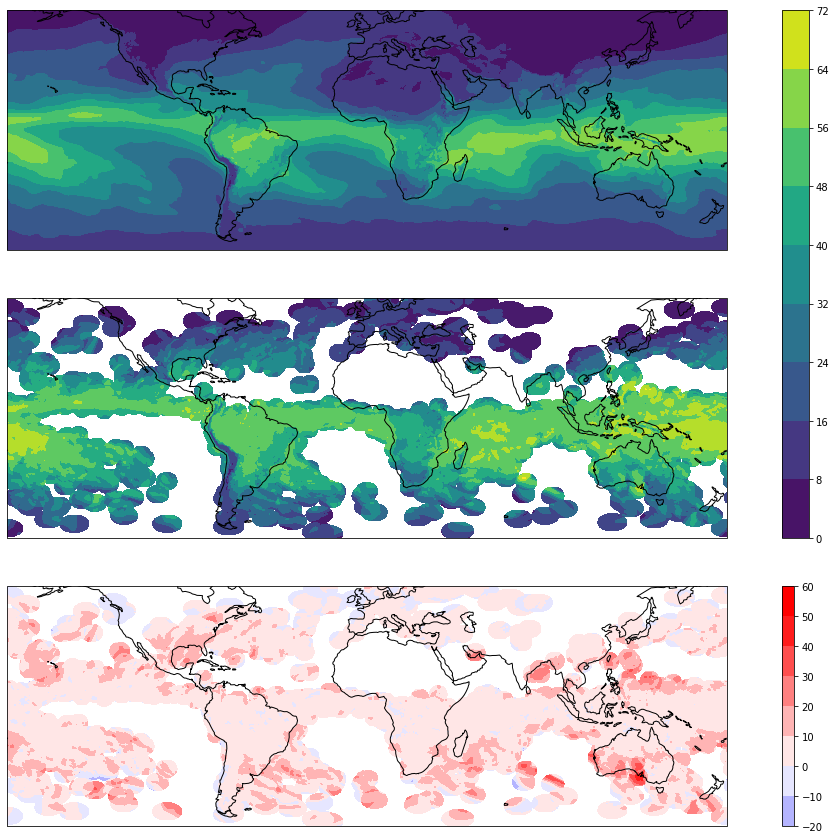

In [28]:
plot_var(ds.isel(time=0), 'tcwv')

In [29]:
plot_var(ds.mean(dim='time'), 'cape')

In [30]:
plot_var(ds.mean(dim='time'), 'tcwv')

0
1
2
3
4
5
6
7
8
9
10
11


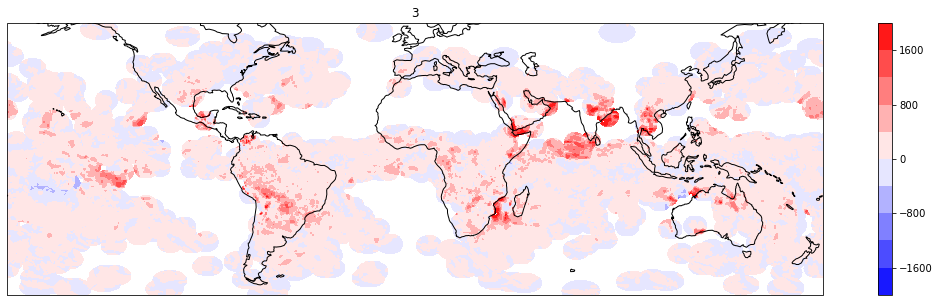

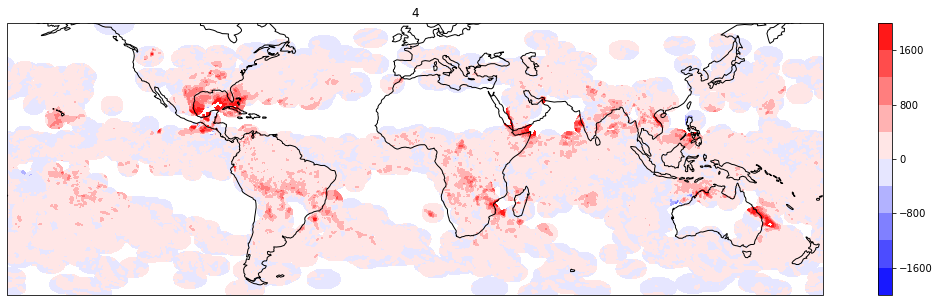

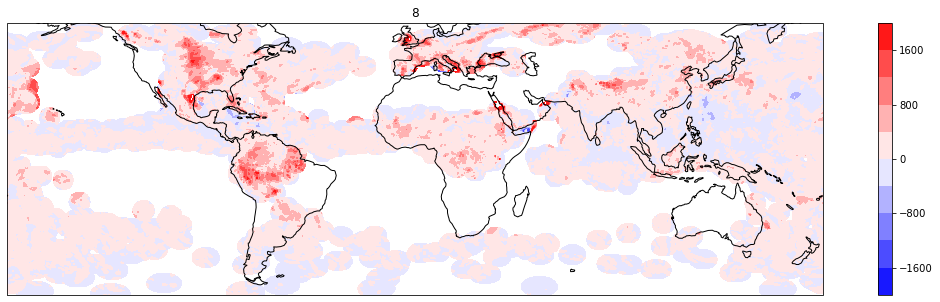

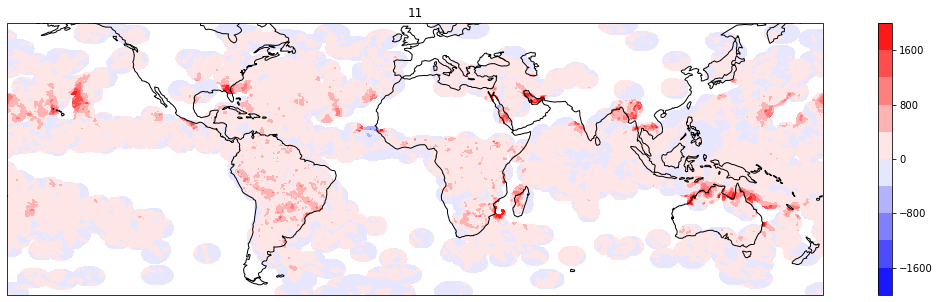

In [31]:
for i in range(12):
    print(i)
    plot_var_diff(ds.isel(time=i), 'cape', i + 1)

0
1
2
3
4
5
6
7
8
9
10
11


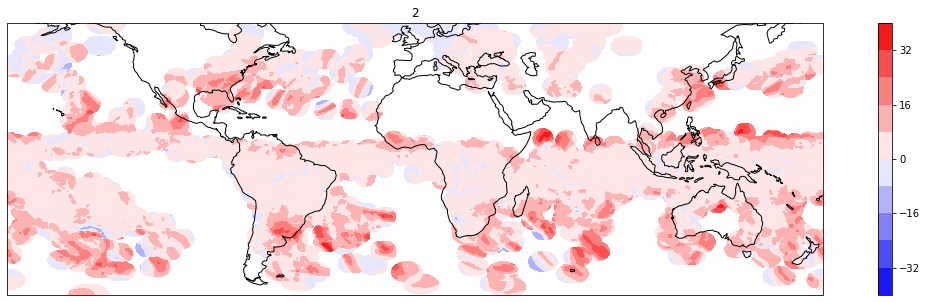

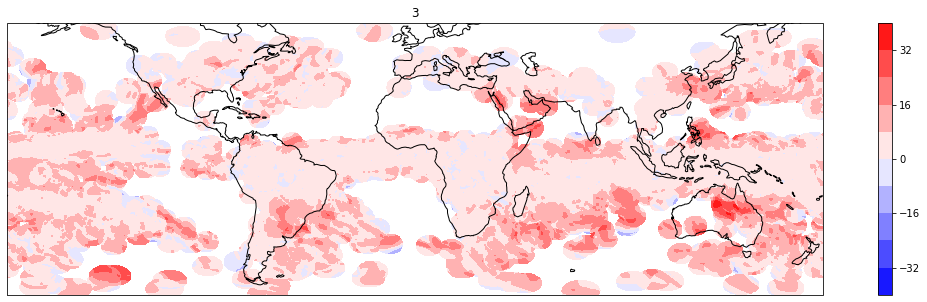

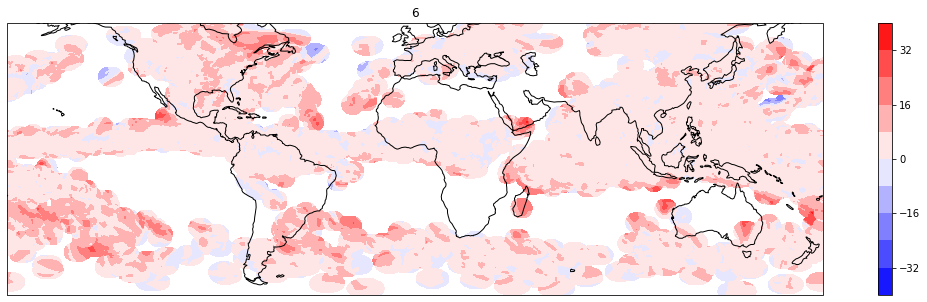

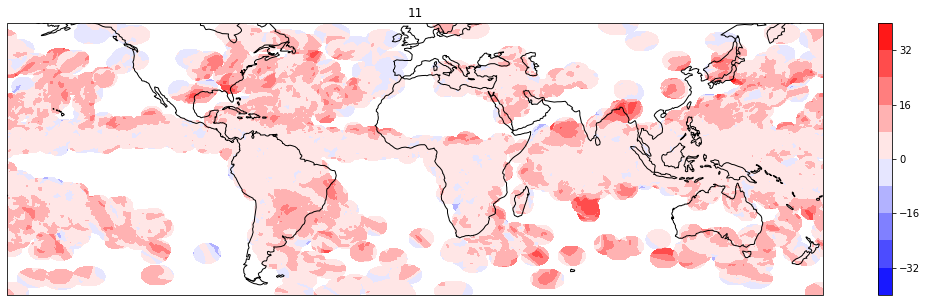

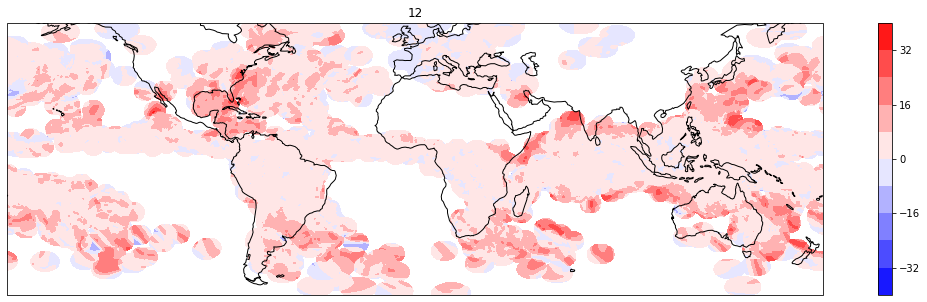

In [34]:
for i in range(12):
    print(i)
    plot_var_diff(ds.isel(time=i), 'tcwv', i + 1)